In [249]:
import tsnet
import matplotlib.pyplot as plt
# open an example network and create a transient model
inp_file = 'Tnet3.inp'
inp_file = 'single_pipe_leak.inp'

emitter_coeffs = [0, 0.01]


tms = [tsnet.network.TransientModel(inp_file) for _ in emitter_coeffs]


# Set wavespeed

for i, tm in enumerate(tms):
    tm.set_wavespeed(1200)
    tf = 20 # simulation period [s]
    tm.set_time(tf)

    # Add leak
    emitter_coeff = 0.01 # [ m^3/s/(m H20)^(1/2)]
    tm.add_leak('J0', emitter_coeffs[i])

    # Initialize steady state simulation
    t0 = 0. # initialize the simulation at 0s
    engine = 'DD' # or Epanet
    tm = tsnet.simulation.Initializer(tm, t0, engine)

    # Transient simulation
    result_obj = f'TSNet_{emitter_coeffs[i]}' # name of the object for saving simulation results
    tm = tsnet.simulation.MOCSimulator(tm,result_obj)

Simulation time step 0.50000 s
Total Time Step in this simulation 40
Estimated simulation time 0:00:00.008560
Transient simulation completed 10 %...
Transient simulation completed 20 %...
Transient simulation completed 30 %...
Transient simulation completed 40 %...
Transient simulation completed 50 %...
Transient simulation completed 60 %...
Transient simulation completed 70 %...
Transient simulation completed 80 %...
Transient simulation completed 90 %...
Simulation time step 0.50000 s
Total Time Step in this simulation 40
Initial condition discrepancy of pressure (-5.7487 m) on the J0 node
Initial condition discrepancy of pressure (-5.7487 m) on the J0 node
Estimated simulation time 0:00:00.004720
Transient simulation completed 10 %...
Transient simulation completed 20 %...
Transient simulation completed 30 %...
Transient simulation completed 40 %...
Transient simulation completed 50 %...
Transient simulation completed 60 %...
Transient simulation completed 70 %...
Transient simulati

/Users/johanslettengren/miniconda3/envs/df_env/lib/python3.10/site-packages/wntr/network/options.py:420: UserWarning: Changing the headloss formula from H-W to D-W will not change the units of the roughness coefficient.
  warnings.warn('Changing the headloss formula from ' +


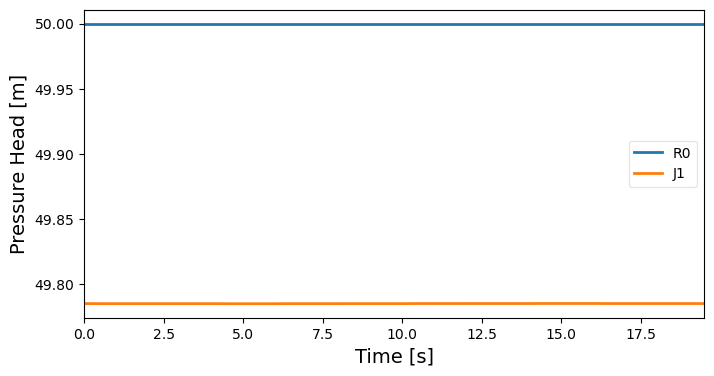

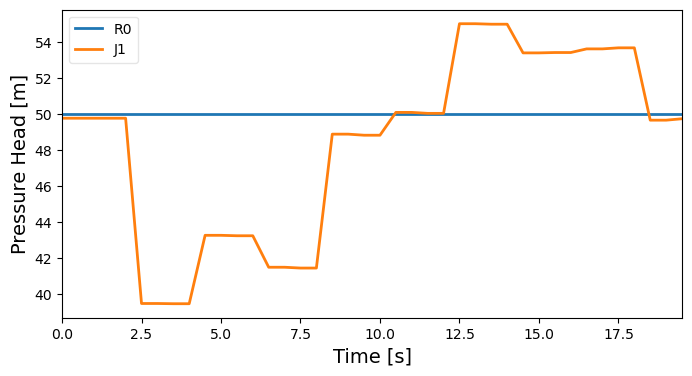

In [256]:
node = ['R0', 'J1']

for tm in tms:
    tm.plot_node_head(node)

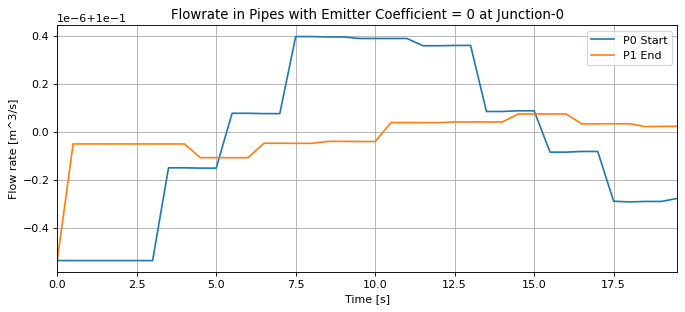

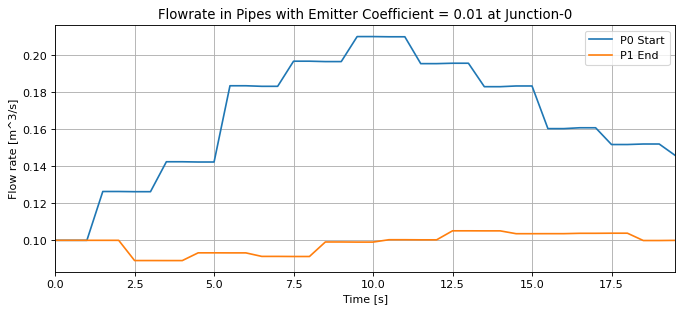

In [253]:
for i, tm in enumerate(tms):
    p0 = tm.get_link('P0')
    p1 = tm.get_link('P1')

    fig2 = plt.figure(figsize=(10,4), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(tm.simulation_timestamps,p0.start_node_flowrate, label='P0 Start')
    #plt.plot(tm.simulation_timestamps,p0.end_node_flowrate, label='P0 End')

    #plt.plot(tm.simulation_timestamps,p1.start_node_flowrate, label='P1 Start')
    plt.plot(tm.simulation_timestamps,p1.end_node_flowrate, label='P1 End')

    plt.xlim([tm.simulation_timestamps[0],tm.simulation_timestamps[-1]])
    plt.title(f'Flowrate in Pipes with Emitter Coefficient = {emitter_coeffs[i]} at Junction-0')
    plt.xlabel("Time [s]")
    plt.ylabel("Flow rate [m^3/s]")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()